Murt Sayeed

# Part One: Logistic Regression for Digit Classification

Import required libraries

In [1]:
import os
import numpy as np
import pandas as pd
import csv
import operator
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import sklearn.linear_model
import sklearn.tree
import sklearn.metrics
from sklearn.metrics import log_loss
import scipy

from matplotlib import pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn import model_selection
import sklearn.metrics

from sklearn.utils.testing import ignore_warnings
from sklearn.exceptions import ConvergenceWarning
from scipy import stats
from scipy.special import boxcox1p
from scipy.ndimage.filters import gaussian_filter

import seaborn as sns
%matplotlib inline
plt.style.use('seaborn')

Upload the data from csv files - ignore the headers.

In [2]:
x_tr = np.loadtxt('./data_digits_8_vs_9_noisy/x_train.csv', delimiter=',', skiprows=1)
x_te = np.loadtxt('./data_digits_8_vs_9_noisy/x_test.csv', delimiter=',', skiprows=1)
y_tr = np.loadtxt('./data_digits_8_vs_9_noisy/y_train.csv', delimiter=',', skiprows=1)
y_te = np.loadtxt('./data_digits_8_vs_9_noisy/y_test.csv', delimiter=',', skiprows=1)

1.1 Multiple Iterations Comparison via scoring and LogLoss

In [3]:
#sh
@ignore_warnings(category=ConvergenceWarning) 
def log_reg_iterations_vs_accuracy(input_set, output_set):
    ''' Performs logistic regression on 784 feature data
       
    Args
    ----
    input_set: 784 feature set representing a noisy digit image
    output_set: 1D array representing 0 (if digit is 8), or 1, if digit is 9

    
    Returns
    -------
    iterations_v_score: 2D list containing an array representing the num of iterations, and another respective
    array representing the score() (accuracy) of the model to be plotted.
    
    '''
    iteration = []
    score_list = []
    iterations_v_score = []
    for i in range(1, 41):
        logreg = LogisticRegression(solver='liblinear', max_iter = i)
        logreg.fit(input_set, output_set)
        sc = logreg.score(input_set, output_set)
        iteration.append(i)
        score_list.append(sc)
    iterations_v_score.append(iteration)
    iterations_v_score.append(score_list)
    return iterations_v_score


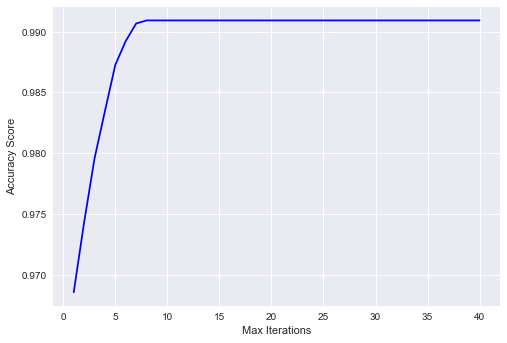

In [4]:
# # of iterations vs accuracy
iter_v_acc = log_reg_iterations_vs_accuracy(x_tr, y_tr)

plt.xlabel('Max Iterations');
plt.ylabel('Accuracy Score');
plt.plot(iter_v_acc[0], iter_v_acc[1], color="blue" ,label = "Score Curve");

In [5]:
@ignore_warnings(category=ConvergenceWarning)
def log_reg_iterations_vs_logloss(input_set, output_set):
    ''' Performs logistic regression on 784 feature data
       
    Args
    ----
    input_set: 784 feature set representing a noisy digit image
    output_set: 1D array representing 0 (if digit is 8), or 1, if digit is 9

    
    Returns
    -------
    iterations_v_score: 2D list containing an array representing the num of iterations, and another respective
    array representing the logloss of the model to be plotted.
    
    '''
    iteration = []
    logloss_list = []
    iterations_v_logloss = []
    for i in range(1, 41):
        logreg = LogisticRegression(solver='liblinear', max_iter = i)
        logreg.fit(input_set, output_set)
        prob_float = logreg.predict_proba(input_set)
        logloss = log_loss(output_set, prob_float)
        iteration.append(i)
        logloss_list.append(logloss)
    iterations_v_logloss.append(iteration)
    iterations_v_logloss.append(logloss_list)
    return iterations_v_logloss

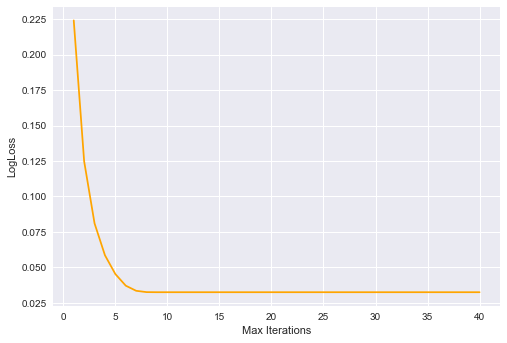

In [6]:

# # of iterations vs log loss

iter_v_logloss = log_reg_iterations_vs_logloss(x_tr, y_tr)

plt.xlabel('Max Iterations');
plt.ylabel('LogLoss');
plt.plot(iter_v_logloss[0], iter_v_logloss[1], color="orange", label = "Loss Curve");
# plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)

DISCUSSION: Place these plots into your PDF document, with captions labeling each appropriately.
Below the plots, discuss the results you are seeing; what do they show, and why?

1.2 Iterations v. Weight

In [7]:
@ignore_warnings(category=ConvergenceWarning)
def log_reg_iterations_vs_initial_weight(input_set, output_set):
    ''' Performs logistic regression on 784 feature data
       
    Args
    ----
    input_set: 784 feature set representing a noisy digit image
    output_set: 1D array representing 0 (if digit is 8), or 1, if digit is 9

    
    Returns
    -------
    iterations_v_weight: 2D list containing an array representing the num of iterations, and another respective
    array representing the first weight, that of the feature 'pixel000' in the input data
    
    '''
    iteration = []
    first_weight = []
    iterations_v_firstweight = []
    for i in range(1, 41):
        logreg = LogisticRegression(solver='liblinear', max_iter = i)
        logreg.fit(input_set, output_set)
        coef = logreg.coef_[0][0]
        iteration.append(i)
        first_weight.append(coef)
    iterations_v_firstweight.append(iteration)
    iterations_v_firstweight.append(first_weight)
    return iterations_v_firstweight

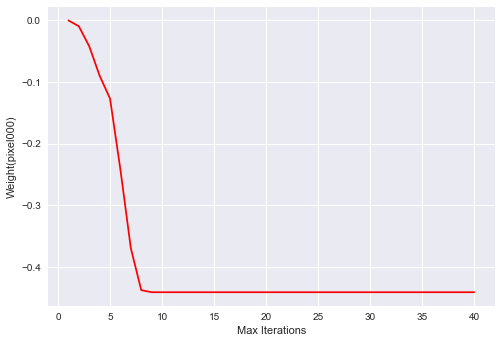

In [8]:
# # of iterations vs first initial feature

iterations_v_firstweight = log_reg_iterations_vs_initial_weight(x_tr, y_tr)

plt.xlabel('Max Iterations');
plt.ylabel('Weight(pixel000)');
plt.plot(iterations_v_firstweight[0], iterations_v_firstweight[1], color="red");

1.3

In [9]:
##sh
def calc_confusion_matrix_for_threshold(ytrue_N, yproba1_N, thresh):
    ''' Compute the confusion matrix for a given probabilistic classifier and threshold
    
    Args
    ----
    ytrue_N : 1D array of floats
        Each entry represents the binary value (0 or 1) of 'true' label of one example
        One entry per example in current dataset
    yproba1_N : 1D array of floats
        Each entry represents a probability (between 0 and 1) that correct label is positive (1)
        One entry per example in current dataset
        Needs to be same size as ytrue_N
    thresh : float
        Scalar threshold for converting probabilities into hard decisions
        Calls an example "positive" if yproba1 >= thresh

    Returns
    -------
    cm_df : Pandas DataFrame
        Can be printed like print(cm_df) to easily display results
    '''
    cm = sklearn.metrics.confusion_matrix(ytrue_N, yproba1_N >= thresh)
    cm_df = pd.DataFrame(data=cm, columns=[0, 1], index=[0, 1])
    cm_df.columns.name = 'Predicted'
    cm_df.index.name = 'True'
    return cm_df

@ignore_warnings(category=ConvergenceWarning)
def log_reg_inverse_penalty(input_set, output_set, test_set, y_true):
    ''' Performs logistic regression on 784 feature data
       
    Args
    ----
    input_set: 784 feature input data representing digits 8 or 9
    output_set: 1D array representing 0 (if digit is 8), or 1, if digit is 9

    Returns
    -------
    stdout: inverse penalty value that gives least log-loss on test set, accuracy score of the model, and confusion
    matrix
    cm_df: dataframe containing confusion matrix for best model (with greatest accuracy given an inverse penalty value c)
    '''
    C_grid = np.logspace(-9, 6, 31)
    loss_list = []
    c_list = []
    score_list = []
    for c in C_grid:
        logreg = LogisticRegression(C=c, solver='liblinear')
        logreg.fit(input_set, output_set)
        prob_float = logreg.predict_proba(test_set)
        logloss = log_loss(y_true, prob_float)
        loss_list.append(logloss)
        c_list.append(c)
        score_list.append(logreg.score(input_set, output_set))
    
    least_log_loss = min(loss_list)
    corresponding_c_val = c_list[loss_list.index(min(loss_list))]
    corresponding_score = score_list[loss_list.index(min(loss_list))]
    
    logreg = LogisticRegression(C=corresponding_c_val, solver='liblinear')
    logreg.fit(input_set, output_set)
    coef = logreg.coef_[0]
    y_pred_actual = logreg.predict(test_set)
    print(y_pred_actual[0])
    
    f_n = []
    f_p = []
    for i in range(len(y_true)):
        if y_true[i] != y_pred_actual[i] and y_true[i] == 0.0:
            f_p.append(np.asarray(input_set[i]))
            
    for i in range(len(y_true)):
        if y_true[i] != y_pred_actual[i] and y_true[i] == 1.0:
            f_n.append(np.asarray(input_set[i]))
            
    f_p = f_p[:9]
    f_n = f_n[:9]
    
    print("The minimum log loss is " + str(least_log_loss) + ".")
    print("The corresponding inverse penalty value is " + str(corresponding_c_val) + ".")
    print("The corresponding accuracy value is " + str(corresponding_score) + ".")  
            
    cm = sklearn.metrics.confusion_matrix(y_true, y_pred_actual)
    cm_df = pd.DataFrame(data=cm, columns=[0, 1], index=[0, 1])
    cm_df.columns.name = 'Predicted'
    cm_df.index.name = 'True'
    return cm_df, f_p, f_n, coef

    
result_inv_penalty = log_reg_inverse_penalty(x_tr, y_tr, x_te, y_te)
print(result_inv_penalty[0])

1.0
The minimum log loss is 0.08968955614249495.
The corresponding inverse penalty value is 0.03162277660168379.
The corresponding accuracy value is 0.9808474576271187.
Predicted    0    1
True               
0          942   32
1           33  976


NameError: name 'C_grid' is not defined

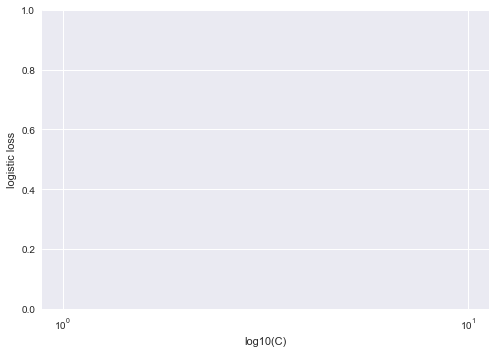

In [10]:
plt.xscale('log')
plt.xlabel('log10(C)')
plt.ylabel('logistic loss')
plt.plot(C_grid,loss_list, color='orange',label = "Log Loss")

plt.legend()
plt.show()

In [ ]:
def reshape_arr(arr):
    array = np.zeros([28, 28])
    count  = 0
    for i in range(len(array)):
        for j in range(len(array[i])):
            element = arr[count]
            array[i][j] = element
            count+=1
    return array

def reshape_all(arr):
    ret = []
    for i in arr:
        i = reshape_arr(i)
        ret.append(i)
    return ret

fp_data = reshape_all(result_inv_penalty[1])

In [ ]:
# False Positives
fig = plt.figure()
ax1 = fig.add_subplot(3,3,1)
ax1.imshow(fp_data[0], cmap='Greys', vmin=0.0, vmax=1.0)
ax2 = fig.add_subplot(3,3,2)
ax2.imshow(fp_data[1], cmap='Greys', vmin=0.0, vmax=1.0)
ax3 = fig.add_subplot(3,3,3)
ax3.imshow(fp_data[2], cmap='Greys', vmin=0.0, vmax=1.0)
ax4 = fig.add_subplot(3,3,4)
ax4.imshow(fp_data[3], cmap='Greys', vmin=0.0, vmax=1.0)
ax5 = fig.add_subplot(3,3,5)
ax5.imshow(fp_data[4], cmap='Greys', vmin=0.0, vmax=1.0)
ax6 = fig.add_subplot(3,3,6)
ax6.imshow(fp_data[5], cmap='Greys', vmin=0.0, vmax=1.0)
ax7 = fig.add_subplot(3,3,7)
ax7.imshow(fp_data[6], cmap='Greys', vmin=0.0, vmax=1.0)
ax8 = fig.add_subplot(3,3,8)
ax8.imshow(fp_data[7], cmap='Greys', vmin=0.0, vmax=1.0)
ax9 = fig.add_subplot(3,3,9)
ax9.imshow(fp_data[8], cmap='Greys', vmin=0.0, vmax=1.0)

In [ ]:
fn_data = reshape_all(result_inv_penalty[2])

# False Negatives
fig1 = plt.figure()
ax1 = fig1.add_subplot(3,3,1)
ax1.imshow(fn_data[0], cmap='Greys', vmin=0.0, vmax=1.0)
ax2 = fig1.add_subplot(3,3,2)
ax2.imshow(fn_data[1], cmap='Greys', vmin=0.0, vmax=1.0)
ax3 = fig1.add_subplot(3,3,3)
ax3.imshow(fn_data[2], cmap='Greys', vmin=0.0, vmax=1.0)
ax4 = fig1.add_subplot(3,3,4)
ax4.imshow(fn_data[3], cmap='Greys', vmin=0.0, vmax=1.0)
ax5 = fig1.add_subplot(3,3,5)
ax5.imshow(fn_data[4], cmap='Greys', vmin=0.0, vmax=1.0)
ax6 = fig1.add_subplot(3,3,6)
ax6.imshow(fn_data[5], cmap='Greys', vmin=0.0, vmax=1.0)
ax7 = fig1.add_subplot(3,3,7)
ax7.imshow(fn_data[6], cmap='Greys', vmin=0.0, vmax=1.0)
ax8 = fig1.add_subplot(3,3,8)
ax8.imshow(fn_data[7], cmap='Greys', vmin=0.0, vmax=1.0)
ax9 = fig1.add_subplot(3,3,9)
ax9.imshow(fn_data[8], cmap='Greys', vmin=0.0, vmax=1.0)

In [ ]:
coefficients = result_inv_penalty[3]
coefficients = reshape_arr(coefficients)

# Image Representation of Weights
plt.imshow(coefficients, cmap='RdYlBu', vmin=-0.5, vmax=0.5)

Part Two: Sneakers v. Sandals

In [ ]:
x_tr = np.loadtxt('./data_sneaker_vs_sandal/x_train.csv', delimiter=',', skiprows=1)
x_te = np.loadtxt('./data_sneaker_vs_sandal/x_test.csv', delimiter=',', skiprows=1)
y_tr = np.loadtxt('./data_sneaker_vs_sandal/y_train.csv', delimiter=',', skiprows=1)

In [ ]:
bestC = C_grid[np.argmin(C_loss)]
clf = LogisticRegression(C=bestC,solver='liblinear').fit(x_tr, y_tr)
ypred_te = clf.predict(x_te)
print(calc_confusion_matrix_for_threshold(y_te,ypred_te,0.5))


def transform(X,div):
    re = []
    counter = 1
    tmp = []
    for i in range(len(X)):
        tmp.append(X[i])
        if counter % div == 0:
            re.append(np.array(tmp))
            tmp = []
        counter += 1
    #print (np.array(re).shape)
    return np.array(re)

tt = transform(clf.coef_[0].transpose(),28)

img_sneaker = transform(x_tr[0],28)
matplotlib.pyplot.imshow(X = img_sneaker,cmap='RdYlBu', vmin=0.0, vmax=1.0)

In [ ]:
coefficients = result_inv_penalty[3]
coefficients = reshape_arr(coefficients)

# Image Representation of Weights
plt.imshow(coefficients, cmap='RdYlBu', vmin=-0.5, vmax=0.5)

In [ ]:
x_tr_footwear = np.loadtxt('./data_sneaker_vs_sandal/x_train.csv', delimiter=',', skiprows=1)
x_te_footwear = np.loadtxt('./data_sneaker_vs_sandal/x_test.csv', delimiter=',', skiprows=1)
y_tr_footwear = np.loadtxt('./data_sneaker_vs_sandal/y_train.csv', delimiter=',', skiprows=1)

In [ ]:
@ignore_warnings(category=ConvergenceWarning)
def logreg_no_tuning(input_set, output_set, test_set):
    ''' Performs logistic regression on 784 feature data representing sneaker/sandal image
       
    Args
    ----
    input_set: 784 feature set representing some form of shoeware
    output_set: 1D array representing 0 (if image is a sneaker), or 1, if image is a sandal

    
    Returns
    -------
    stdout - yproba1_test.txt represents one probability value per line, per example in x_test.csv determining
    the probability that a feature set represents a sneaker (class label = 0) or sandal (class label = 1)
    
    '''
    logreg = LogisticRegression(solver='liblinear')
    logreg.fit(input_set, output_set)
    prob_float = logreg.predict_proba(test_set)[:, 1]
    np.savetxt('yproba1_test.txt', prob_float)

logreg_no_tuning(x_tr_footwear, y_tr_footwear, x_te_footwear)


In [ ]:
%%time
def add_horizontal_flip_input(input_set):
    result = []
    for element in input_set:
        result.append(element)
    for element in input_set:
        new_element = np.flipud(element) 
        result.append(new_element)
    return np.array(result)

def add_horizontal_flip_output(output_set):
    result = []
    for element in output_set:
        result.append(element)
    for element in output_set:
        result.append(element)
    return np.array(result)
    
x_tr_footwear_h = add_horizontal_flip_input(x_tr_footwear)
y_tr_footwear_h = add_horizontal_flip_output(y_tr_footwear)

# Error Rate: 0.05300000000000005 
# AUROC: 0.98663
def logreg_data_aug_h(input_set, output_set, test_set):
    ''' Performs logistic regression on 784 feature data (flipped) representing sneaker/sandal image
       
    Args
    ----
    input_set: 784 feature set representing some form of shoeware
    output_set: 1D array representing 0 (if image is a sneaker), or 1, if image is a sandal

    
    Returns
    -------
    stdout - yproba1_test.txt represents one probability value per line, per example in x_test.csv determining
    the probability that a feature set represents a sneaker (class label = 0) or sandal (class label = 1)
    
    '''
    logreg = LogisticRegression(solver='liblinear')
    logreg.fit(input_set, output_set)
    prob_float = logreg.predict_proba(test_set)[:, 1]
    np.savetxt('yproba1_test.txt', prob_float)

logreg_data_aug_h(x_tr_footwear_h, y_tr_footwear_h, x_te_footwear)


In [ ]:
%%time
def logreg_split_2_1(input_set, output_set, test_set):
    ''' Performs logistic regression on 784 feature data using 66% of input_set as training data, and the rest of 
    the 33% as the test data
       
    Args
    ----
    input_set: 784 feature set representing some form of shoeware
    output_set: 1D array representing 0 (if image is a sneaker), or 1, if image is a sandal

    
    Returns
    -------
    stdout - yproba1_test.txt represents one probability value per line, per example in x_test.csv determining
    the probability that a feature set represents a sneaker (class label = 0) or sandal (class label = 1)
    
    '''
    test_size = 0.33 #2:1 split
    seed = 7 #for reproducibility
    X_train, X_test, Y_train, Y_test = model_selection.train_test_split(input_set, output_set, test_size=test_size, random_state=seed)
    logreg = LogisticRegression(solver='liblinear')
    logreg.fit(X_train, Y_train)
    prob_float = logreg.predict_proba(test_set)[:, 1]
    np.savetxt('yproba1_test.txt', prob_float)
    
logreg_split_2_1(x_tr_footwear, y_tr_footwear, x_te_footwear)

In [ ]:
%%time
# Error Rate: 0.04249999999999998
# AUROC: 0.993114
def logreg_k_fold(input_set, output_set, test_set):
    ''' Performs logistic regression on 784 feature data using k-fold cross validation
       
    Args
    ----
    input_set: 784 feature set representing some form of shoeware
    output_set: 1D array representing 0 (if image is a sneaker), or 1, if image is a sandal

    
    Returns
    -------
    stdout - yproba1_test.txt represents one probability value per line, per example in x_test.csv determining
    the probability that a feature set represents a sneaker (class label = 0) or sandal (class label = 1)
    
    '''
    seed = 7 #for reproducibility
    scores = []
    log_reg = LogisticRegression(solver='liblinear')
    kfold = model_selection.KFold(n_splits=10, random_state=seed)
    for train_index, test_index in kfold.split(input_set):
        X_train, X_test, y_train, y_test = input_set[train_index], input_set[test_index], output_set[train_index], output_set[test_index]
        log_reg.fit(X_train, y_train)    
    prob_float = log_reg.predict_proba(test_set)[:, 1]
    np.savetxt('yproba1_test.txt', prob_float)

logreg_k_fold(x_tr_footwear, y_tr_footwear, x_te_footwear)